# Endometriosis analysis - preprocessing
## Cells - Mareckova

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0


'/opt/conda/bin/python'

# Import data
## Import sample metadata

In [2]:
meta = pd.read_csv('metadata-libraries.csv',index_col=0)
print('Number of samples: ', meta.index.size)
meta['sample'] = meta.index
meta.head()

Number of samples:  288


,StudyName,SampleID,Lane,Processing,Type,BiopsyType,BiopsyType_II,Tissue,Treatment,10x kit,...,genotyped,genotype_file,analysed,N_cells,Reads per Cell,Genes per Cell,QC_single sample analysis,QC_CellRanger,Unnamed: 23,sample
FolderName,,,,,,,,,,,,,,,,,,,,,
HCA_A_RepT_RNA13247830,CBTM,HCA_A_RepT_RNA13247830,0.0,Fresh,Cells,Organ_Donor,Ctrl_Endometrium,None,Coll.+Trypsin,3' v3.1,...,no,none,yes,"8,466","103,917","2,426",NaN,NaN,NaN,HCA_A_RepT_RNA13247830
HCA_A_RepT_RNA13247831,CBTM,HCA_A_RepT_RNA13247831,0.0,Fresh,Cells,Organ_Donor,Ctrl_Endometrium,None,Coll.+Trypsin,3' v3.1,...,no,none,yes,"7,723","109,804","2,796",NaN,Low Fraction Reads in Cells 68% (>70%),NaN,HCA_A_RepT_RNA13247831
HCA_FR_CBTM_12920384,CBTM,A66-RPT-8-SC-1,0.0,Fresh,Cells,Organ_Donor,Ctrl_Endometrium,None,Coll.+Trypsin,3' v3.1,...,no,none,yes,NaN,NaN,NaN,NaN,NaN,NaN,HCA_FR_CBTM_12920384
HCA_FR_CBTM_12920385,CBTM,A66-RPT-8-SC-2,0.0,Fresh,Cells,Organ_Donor,NaN,None,Coll.+Trypsin,3' v3.1,...,no,none,yes,NaN,NaN,NaN,NaN,NaN,NaN,HCA_FR_CBTM_12920385
GSM6574509,Fonseca,Sample1,0.0,Fresh,Cells,Lesion_Ovarian,Lesion_Ovarian,Ovary,NaN,3',...,no,none,no,NaN,NaN,NaN,NaN,NaN,NaN,GSM6574509


In [3]:
# sample_directory = '/lustre/scratch117/cellgen/team292/lh20/magda/'
sample_directory = '/nfs/team292/lg18/endometriosis/data/scRNAseq/'

meta = meta.loc[meta.analysed.str.contains('yes'),:]
meta = meta.loc[meta.Type.str.contains('Cells'),:]
meta = meta.loc[meta.StudyName.str.contains('Marecckovaa'),:]

print('Number of samples: ', meta.index.size)

Number of samples:  22


## Load 10x 

Filter: 1) cells (< 10 genes); 2) genes (< 3 cells) 

Quantify: 1) % mitochondrial genes; 2) total counts


In [4]:
holder = []
for sample in meta.index:
    print(sample)
    # Load 10x data as AnnData
    holder.append(sc.read_10x_mtx(sample_directory+sample+'/filtered_feature_bc_matrix/',cache=True)) 
    # Set names of observation as sample + _ + barcode/probe
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    # Filer cells with less than 10 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=150)
    # add in metadata
    holder[-1].obs['sample'] = sample
    holder[-1].obs['library'] = sample
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo13646709-filtered_feature_bc_matrix-matrix.h5ad


UA_Endo13646709


filtered out 14024 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo9426399-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 2167
Total number of genes: 22577
UA_Endo9426399


filtered out 10070 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo9426400-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 15767
Total number of genes: 26531
UA_Endo9426400


filtered out 12337 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-FRZFRESH_GX25-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 11618
Total number of genes: 24264
FRZFRESH_GX25


filtered out 15098 genes that are detected in less than 3 cells
filtered out 136 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-FRZFRESH_GX26-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 4402
Total number of genes: 21503
FRZFRESH_GX26


filtered out 16243 genes that are detected in less than 3 cells
filtered out 463 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-FRZFRESH_GX27-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 4153
Total number of genes: 20358
FRZFRESH_GX27


filtered out 14429 genes that are detected in less than 3 cells
filtered out 242 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-FRZFRESH_GX28-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 5065
Total number of genes: 22172
FRZFRESH_GX28


filtered out 16657 genes that are detected in less than 3 cells
filtered out 412 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo10768582-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 3804
Total number of genes: 19944
UA_Endo10768582


filtered out 16715 genes that are detected in less than 3 cells
filtered out 43 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo12680032-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 1278
Total number of genes: 19886
UA_Endo12680032


filtered out 11852 genes that are detected in less than 3 cells
filtered out 2 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo10298210-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 3009
Total number of genes: 24749
UA_Endo10298210


filtered out 10487 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo10298211-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 9565
Total number of genes: 26114
UA_Endo10298211


filtered out 13515 genes that are detected in less than 3 cells
filtered out 33 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo10298212-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 2007
Total number of genes: 23086
UA_Endo10298212


filtered out 10080 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo10298213-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 18857
Total number of genes: 26521
UA_Endo10298213


filtered out 12680 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo12680031-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 17823
Total number of genes: 23921
UA_Endo12680031


filtered out 9158 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo9426401-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 15752
Total number of genes: 27443
UA_Endo9426401


filtered out 9504 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo9426402-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 29183
Total number of genes: 27097
UA_Endo9426402


filtered out 14504 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo12680033-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 1851
Total number of genes: 22097
UA_Endo12680033


filtered out 10514 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo12680034-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 13476
Total number of genes: 26087
UA_Endo12680034


filtered out 12119 genes that are detected in less than 3 cells
filtered out 6 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo12961679-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 5493
Total number of genes: 24482
UA_Endo12961679


filtered out 16645 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo12961680-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 2063
Total number of genes: 19956
UA_Endo12961680


filtered out 20314 genes that are detected in less than 3 cells
filtered out 9 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo12961681-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 129
Total number of genes: 16287
UA_Endo12961681


filtered out 15847 genes that are detected in less than 3 cells
filtered out 3 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-team292-lg18-endometriosis-data-scRNAseq-UA_Endo12961682-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 2578
Total number of genes: 20754
UA_Endo12961682


filtered out 16889 genes that are detected in less than 3 cells
filtered out 5 cells that have less than 150 genes expressed


Total number of cells: 1640
Total number of genes: 19712


In [5]:
# confirm N samples
print(len(holder))
# merge datasets
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

22


AnnData object with n_obs × n_vars = 171680 × 30442
    obs: 'n_genes', 'sample', 'library', 'StudyName', 'SampleID', 'Lane', 'Processing', 'Type', 'BiopsyType', 'BiopsyType_II', 'Tissue', 'Treatment', '10x kit', 'genotype0', 'genotype1', 'multiplexed', 'hashed', 'genotyped', 'genotype_file', 'analysed', 'N_cells', 'Reads per Cell', 'Genes per Cell', 'QC_single sample analysis', 'QC_CellRanger', 'Unnamed: 23', 'percent_mito', 'n_counts', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'n_cells-18', 'gene_id

In [6]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['library'].value_counts()

Total number of cells: 171680
Total number of genes: 30442


UA_Endo9426401     29183
UA_Endo10298212    18857
UA_Endo10298213    17823
UA_Endo9426399     15767
UA_Endo12680031    15752
UA_Endo12680033    13476
UA_Endo9426400     11618
UA_Endo10298210     9565
UA_Endo12680034     5493
FRZFRESH_GX27       5065
FRZFRESH_GX25       4402
FRZFRESH_GX26       4153
FRZFRESH_GX28       3804
UA_Endo12680032     3009
UA_Endo12961681     2578
UA_Endo13646709     2167
UA_Endo12961679     2063
UA_Endo10298211     2007
UA_Endo9426402      1851
UA_Endo12961682     1640
UA_Endo10768582     1278
UA_Endo12961680      129
Name: library, dtype: int64

In [8]:
lib = set(adata.obs['library'])
nlib = len(lib)
print('Total number of libraries: {:d}'.format(nlib))

Total number of libraries: 22


## Add genotype from SNPs deconvolution

Note some libraries have multiplexed genotypes, but others don't.
Here we will add a "genotype" metadata where:
 - multiplexed libraries will take if from the demultiplexed.csv
 - non-multiplexed libraries will use it from "genotype0" column


Below a little bit of ugly code to add the genotype into the adata.obs


In [9]:
# SNPdeconvolution = pd.read_csv('demultiplexed.csv',index_col=None)
SNPdeconvolution = pd.read_csv('/nfs/users/nfs_l/lg18/team292/lg18/endometriosis/data/genotypes/demultiplexed_merged.csv',index_col=None)


# subset to libraries in adata
libraries_of_interest = set(adata.obs['sample'])
SNPdeconvolution = SNPdeconvolution[ pd.DataFrame(SNPdeconvolution.library.tolist()).isin(libraries_of_interest).any(1).values ]

# create Library_barcode ids
SNPdeconvolution['barcode'] = SNPdeconvolution['barcode'].str.replace('-1', '')
SNPdeconvolution['Library_barcode'] = SNPdeconvolution[['library', 'barcode']].apply(lambda x: '_'.join(x), axis=1)
SNPdeconvolution['Library_genotype'] = SNPdeconvolution[['library', 'genotype']].apply(lambda x: '_'.join(x), axis=1)
SNPdeconvolution = SNPdeconvolution.set_index('Library_barcode')

SNPdeconvolution.head()

,library,barcode,genotype,source,Library_genotype
Library_barcode,,,,,
FRZFRESH_GX25_AAACCCAAGGCTTTCA,FRZFRESH_GX25,AAACCCAAGGCTTTCA,ES345,LFHandfield,FRZFRESH_GX25_ES345
FRZFRESH_GX25_AAACCCACAAGCTCTA,FRZFRESH_GX25,AAACCCACAAGCTCTA,ES345,LFHandfield,FRZFRESH_GX25_ES345
FRZFRESH_GX25_AAACCCAGTACCTGTA,FRZFRESH_GX25,AAACCCAGTACCTGTA,ES345,LFHandfield,FRZFRESH_GX25_ES345
FRZFRESH_GX25_AAACCCAGTACGGTTT,FRZFRESH_GX25,AAACCCAGTACGGTTT,ES345,LFHandfield,FRZFRESH_GX25_ES345
FRZFRESH_GX25_AAACCCAGTAGATCGG,FRZFRESH_GX25,AAACCCAGTAGATCGG,ES345,LFHandfield,FRZFRESH_GX25_ES345


In [10]:
# map genotypes
annot = SNPdeconvolution['genotype'].to_dict()
adata.obs['genotype'] = adata.obs.index.map(annot)
print(adata.obs['genotype'].value_counts())

x = SNPdeconvolution.groupby(['library','genotype']).size().reset_index().rename(columns={0:'count'})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(x)

FX1156        28625
FX9006        28316
FX1146        26721
ES345         17423
FX1259        14808
doublet       13955
FX1249         9323
FX1254         7558
FX1125         6050
FX1176         4906
unassigned     3189
FX1119         2093
SE03           1554
FX1253         1278
FX1289          533
SE02            524
FX1285          398
Name: genotype, dtype: int64
            library    genotype  count
0     FRZFRESH_GX25       ES345   6425
1     FRZFRESH_GX26       ES345   5403
2     FRZFRESH_GX27       ES345   6335
3     FRZFRESH_GX28       ES345   4577
4   UA_Endo10298210      FX1125   5923
5   UA_Endo10298210      FX1176   3094
6   UA_Endo10298210     doublet    414
7   UA_Endo10298210  unassigned    135
8   UA_Endo10298211      FX1125    128
9   UA_Endo10298211      FX1176   1815
10  UA_Endo10298211     doublet     27
11  UA_Endo10298211  unassigned     70
12  UA_Endo10298212      FX1156   5953
13  UA_Endo10298212      FX9006  10672
14  UA_Endo10298212     doublet   1759
15  UA_

In [11]:
# for non multiplexed libraries, use genotype0
# adata.obs.loc[adata.obs['genotype1'] == '', 'genotype'] = adata.obs['genotype0']
nomultiplexed_libraries = set(meta.loc[meta.multiplexed.str.contains('no'),:].index)
for sclib in nomultiplexed_libraries:
    print(sclib)
    s_geno = adata.obs['genotype0'][ adata.obs['library'] == sclib ]
    adata.obs.at[ adata.obs['library'] == sclib, 'genotype'] = s_geno[0]

FRZFRESH_GX26
FRZFRESH_GX27
FRZFRESH_GX28
UA_Endo10768582
UA_Endo9426399
UA_Endo12680032
UA_Endo9426400
FRZFRESH_GX25
UA_Endo13646709


Note there are some missing barcodes because demultiplexing was uncocnlusive, generally due to low number of reads.

In [12]:
missing_barcodes = list(set(adata.obs.index) - set(SNPdeconvolution.index)) 
pd.DataFrame(missing_barcodes).to_csv('missing_barcodes.csv', index=None)
print(len(missing_barcodes))

missing_adata =  adata[ missing_barcodes ]
print(missing_adata.obs.genotype1.value_counts())
print(missing_adata.obs.library.value_counts())

4426
FX1254    1143
Name: genotype1, dtype: int64
UA_Endo13646709    2167
UA_Endo12680033    1143
UA_Endo9426400      638
UA_Endo12680032     451
UA_Endo9426399       26
FRZFRESH_GX26         1
Name: library, dtype: int64


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Here we remove them from the andata as we don;t have the genotype

In [13]:
# These libraries have missing barcodes - this is because I am re-genotyping them
# UA_Endo12961679
# UA_Endo12961680
# UA_Endo12961681
# UA_Endo12961682
# UA_Endo12680033
# UA_Endo12680034
na_adata = adata[ adata.obs.genotype.isna() ]
na_barcodes = na_adata.obs.index
len(na_barcodes)
print(na_adata.obs.genotype1.value_counts())
print(na_adata.obs.library.value_counts())

FX1254    1143
Name: genotype1, dtype: int64
UA_Endo12680033    1143
Name: library, dtype: int64


In [14]:
# These barcodes have non missing genotype
adata = adata[ np.invert(adata.obs.genotype.isna()) ]

In [15]:
sampleID = [ i + '_' for i in adata.obs['library'] ]
sampleID = [a + b for a, b in zip(sampleID, adata.obs.genotype.tolist())]

adata.obs['Library_genotype'] = sampleID
adata.obs['sample'] = sampleID

Trying to set attribute `.obs` of view, copying.


In [16]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
print('Total number of samples: {:d}'.format(len(set(adata.obs['Library_genotype']))))
print('Total number of donors: {:d}'.format(len(set(adata.obs['genotype']))))
print('Total number of libraries: {:d}'.format(len(set(adata.obs['library']))))

Total number of cells: 170537
Total number of genes: 30442
Total number of samples: 60
Total number of donors: 18
Total number of libraries: 22


## Add sample metadata

In [17]:
meta_sample = pd.read_csv('metadata-libraries_deconvoluted.csv',index_col=1)
meta_sample


annot = meta_sample['Biopsy_type'].to_dict()
adata.obs['Biopsy_type'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Biopsy_type'].value_counts())

annot = meta_sample['Tissue_sampled'].to_dict()
adata.obs['Tissue_sampled'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Tissue_sampled'].value_counts())

annot = meta_sample['Group'].to_dict()
adata.obs['Group'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Group'].value_counts())

annot = meta_sample['Spatial_location'].to_dict()
adata.obs['Spatial_location'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Spatial_location'].value_counts())

annot = meta_sample['Ectopic_group'].to_dict()
adata.obs['Ectopic_group'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Ectopic_group'].value_counts())

annot = meta_sample['BiopsyType_old'].to_dict()
adata.obs['BiopsyType_old'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['BiopsyType_old'].value_counts())

annot = meta_sample['Tissue'].to_dict()
adata.obs['Tissue'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Tissue'].value_counts())

annot = meta_sample['Treatment'].to_dict()
adata.obs['Treatment'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Treatment'].value_counts())

annot = meta_sample['10x kit'].to_dict()
adata.obs['10x kit'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['10x kit'].value_counts())


annot = meta_sample['Processing'].to_dict()
adata.obs['Processing'] = adata.obs.Library_genotype.map(annot)
print(adata.obs['Processing'].value_counts())

Superficial_Eutopic    152115
Ectopic_Lesion           1278
Name: Biopsy_type, dtype: int64
eutopic_endometrium       152115
ectopic_ovarian_lesion      1278
Name: Tissue_sampled, dtype: int64
Endo_Superficial    100968
Ctrl_Superficial     51147
Lesion_Ovarian        1278
Name: Group, dtype: int64
ovary    1278
Name: Spatial_location, dtype: int64
ovarian    1278
Name: Ectopic_group, dtype: int64
Superficial       152115
Lesion_Ovarian      1278
Name: BiopsyType_old, dtype: int64
None    153393
Name: Tissue, dtype: int64
Collagenase      103136
Trypsin           48979
Coll.+Trypsin      1278
Name: Treatment, dtype: int64
3' v3.1    151226
3' v3.0      2167
Name: 10x kit, dtype: int64
Frozen    144838
Fresh       8555
Name: Processing, dtype: int64


## Add donor metadata

In [19]:
meta_donors = pd.read_csv('metadata-donors.csv',index_col=None)
meta_donors = meta_donors.set_index('Donor')
meta_donors


annot = meta_donors['Endometriosis_stage'].to_dict()
adata.obs['Endometriosis_stage'] = adata.obs.genotype.map(annot)
set(adata.obs['Endometriosis_stage'])

annot = meta_donors['Ectopic_EcP_EcO_EcPA_EcP-D'].to_dict()
adata.obs['Ectopic_EcP_EcO_EcPA_EcP-D'] = adata.obs.genotype.map(annot)
set(adata.obs['Ectopic_EcP_EcO_EcPA_EcP-D'])

annot = meta_donors['Peritoneal_Ovarian_DIE'].to_dict()
adata.obs['Peritoneal_Ovarian_DIE'] = adata.obs.genotype.map(annot)
set(adata.obs['Peritoneal_Ovarian_DIE'])

annot = meta_donors['Hormonal treatment'].to_dict()
adata.obs['Hormonal treatment'] = adata.obs.genotype.map(annot)
set(adata.obs['Hormonal treatment'])

annot = meta_donors['Age'].to_dict()
adata.obs['Age'] = adata.obs.genotype.map(annot)
set(adata.obs['Age'])

annot = meta_donors['Location'].to_dict()
adata.obs['Location'] = adata.obs.genotype.map(annot)
set(adata.obs['Location'])

annot = meta_donors['Binary Stage'].to_dict()
adata.obs['Binary Stage'] = adata.obs.genotype.map(annot)
print(adata.obs['Binary Stage'].value_counts())

annot = meta_donors['Stage'].to_dict()
adata.obs['Stage'] = adata.obs.genotype.map(annot)
adata.obs['Stage'].value_counts()

Secretory        74365
Proliferative    58702
Hormones         18159
Menstrual         2167
Name: Binary Stage, dtype: int64


Secretory Early             45740
Proliferative               37082
Secretory Mid               28625
Proliferative Late          15792
Hormones                    10601
Hormones Menstrual           7558
Proliferative Disordered     4906
Menstrual                    2167
Proliferative Early           922
Name: Stage, dtype: int64

In [25]:
x = adata[[ i not in ['Hormones', 'Menstrual', 'Proliferative', 'Secretory'] for i in adata.obs['Binary Stage'] ]]
set(x.obs.genotype)

{'doublet', 'unassigned'}

In [26]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
print('Total number of donors: {:d}'.format(len(set(adata.obs.genotype))))
print('Total number of samples: {:d}'.format(len(set(adata.obs['Library_genotype']))))
print('Total number of libraries: {:d}'.format(len(set(adata.obs['library']))))

Total number of cells: 170537
Total number of genes: 30442
Total number of donors: 18
Total number of samples: 60
Total number of libraries: 22


## QC pplots

Plot distributions of the values n_genes, n_counts and percent_mito

normalizing counts per cell
    finished (0:00:03)


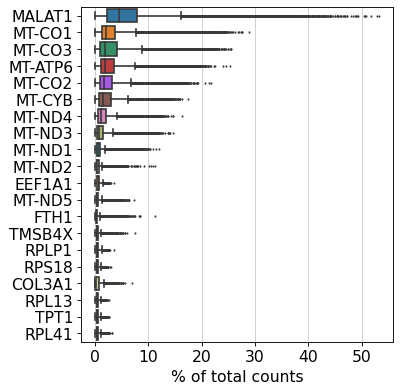

In [27]:
sc.pl.highest_expr_genes(adata, n_top=20)
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [28]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf', show=False)

... storing 'sample' as categorical
... storing 'library' as categorical
... storing 'StudyName' as categorical
... storing 'SampleID' as categorical
... storing 'Processing' as categorical
... storing 'Type' as categorical
... storing 'BiopsyType' as categorical
... storing 'BiopsyType_II' as categorical
... storing 'Tissue' as categorical
... storing 'Treatment' as categorical
... storing '10x kit' as categorical
... storing 'genotype0' as categorical
... storing 'genotype1' as categorical
... storing 'multiplexed' as categorical
... storing 'hashed' as categorical
... storing 'genotyped' as categorical
... storing 'genotype_file' as categorical
... storing 'analysed' as categorical
... storing 'N_cells' as categorical
... storing 'Reads per Cell' as categorical
... storing 'Genes per Cell' as categorical
... storing 'QC_single sample analysis' as categorical
... storing 'QC_CellRanger' as categorical
... storing 'Unnamed: 23' as categorical
... storing 'genotype' as categorical
... 

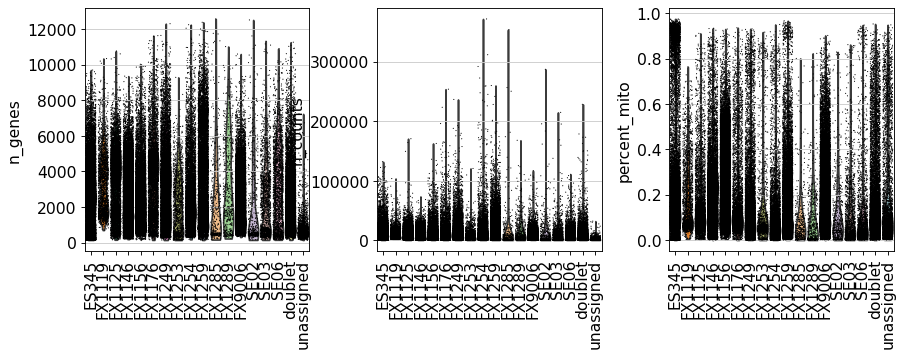

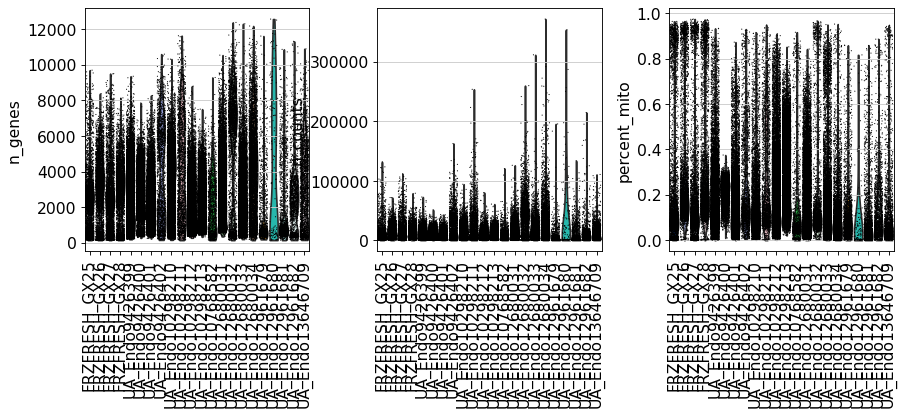

In [29]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='genotype', rotation = 90, jitter=0.4, save='_genotype.pdf', show=True)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='library', rotation = 90, jitter=0.4, save='_library.pdf', show=True)

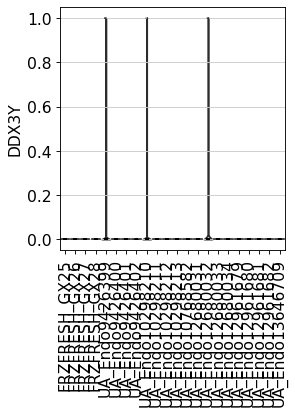

In [30]:
sc.pl.violin(adata, ['DDX3Y'], groupby='library', rotation = 90) # MALE

## General summaries

In [31]:
adata.obs['library'].values.describe()
adata.obs['Library_genotype'].values.describe()

,counts,freqs
categories,,
FRZFRESH_GX25_ES345,4402,0.025813
FRZFRESH_GX26_ES345,4153,0.024352
FRZFRESH_GX27_ES345,5065,0.029700
FRZFRESH_GX28_ES345,3804,0.022306
UA_Endo9426399_FX1146,15767,0.092455
UA_Endo9426400_FX1146,11618,0.068126
UA_Endo9426401_FX1156,9081,0.053249
UA_Endo9426401_FX9006,13257,0.077737
UA_Endo9426401_doublet,6109,0.035822


### Filter cells with few genes
Check number of genes per cell distribution and filter cells accordingly

UA_Endo9426400_FX1146


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


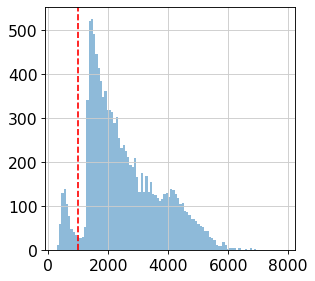

UA_Endo12680031_FX1259


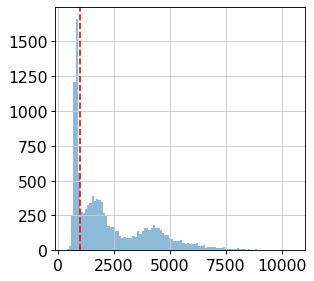

UA_Endo12961680_unassigned


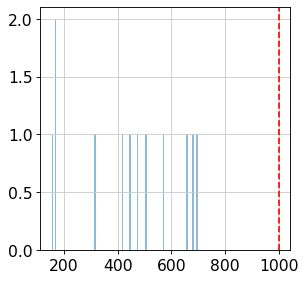

UA_Endo10298212_FX1156


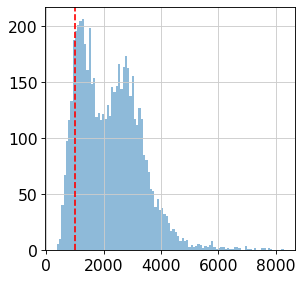

UA_Endo10298211_doublet


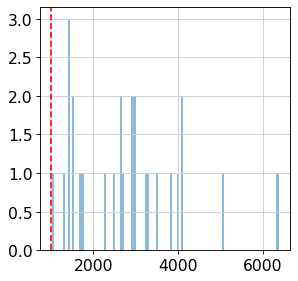

UA_Endo10298210_FX1176


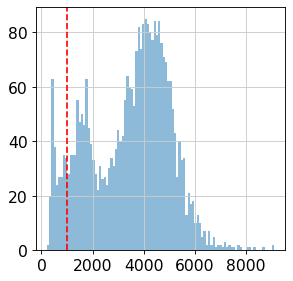

UA_Endo12680034_doublet


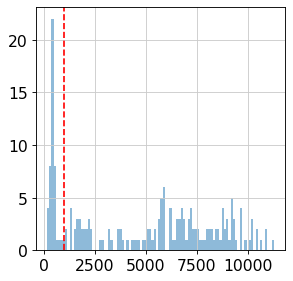

UA_Endo12961679_FX1285


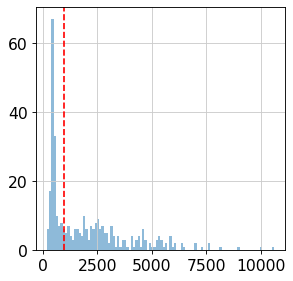

UA_Endo12961679_SE02


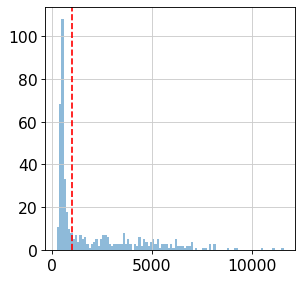

UA_Endo10298210_unassigned


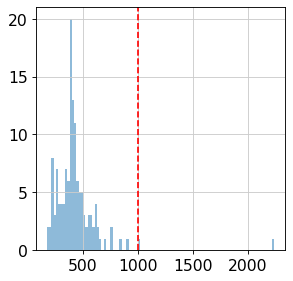

UA_Endo10298213_doublet


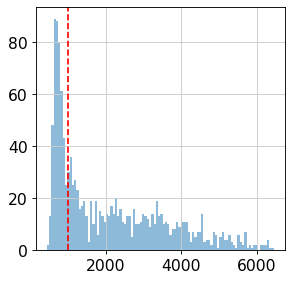

UA_Endo10298210_FX1125


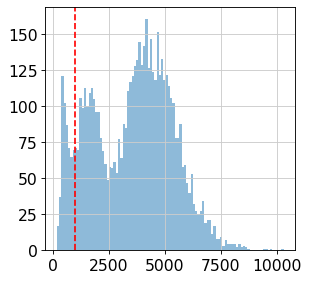

UA_Endo12961682_SE03


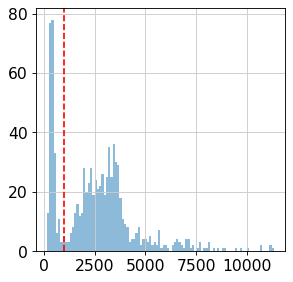

UA_Endo12961682_doublet


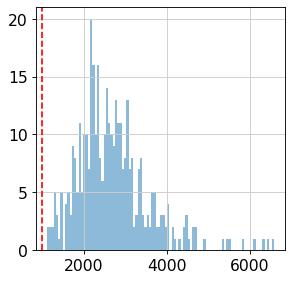

UA_Endo12680034_unassigned


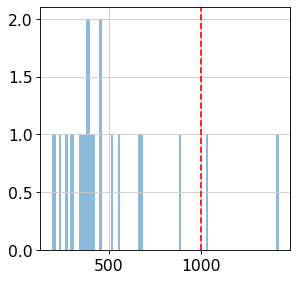

UA_Endo12961680_FX1285


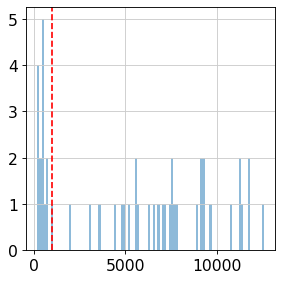

UA_Endo9426399_FX1146


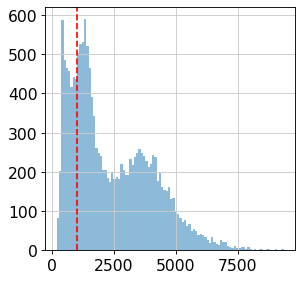

UA_Endo12680033_FX1254


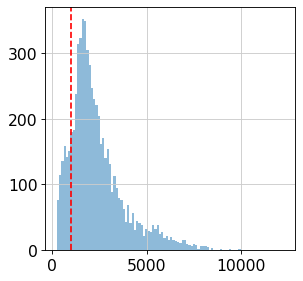

FRZFRESH_GX27_ES345


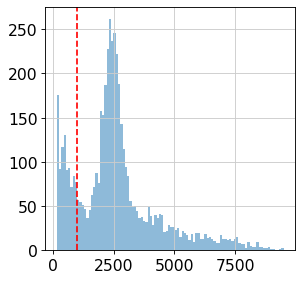

UA_Endo12961680_SE02


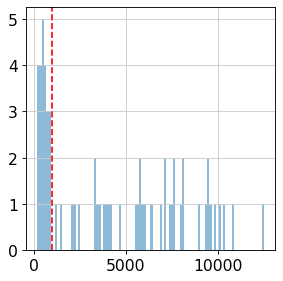

UA_Endo12680031_unassigned


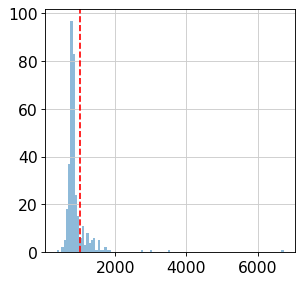

UA_Endo9426402_unassigned


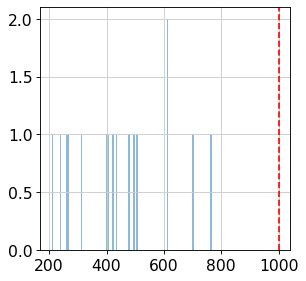

UA_Endo10298212_FX9006


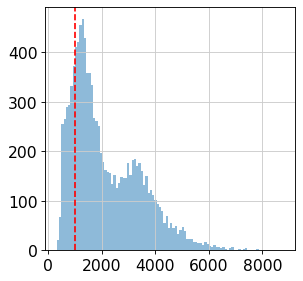

UA_Endo9426401_FX9006


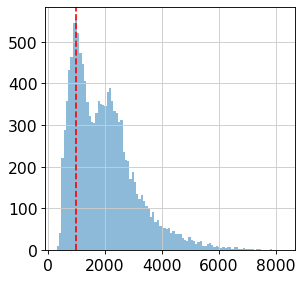

UA_Endo9426402_FX1156


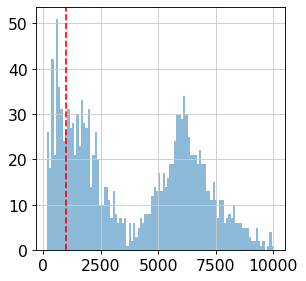

UA_Endo10298212_doublet


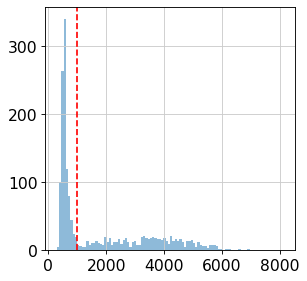

UA_Endo10298211_FX1125


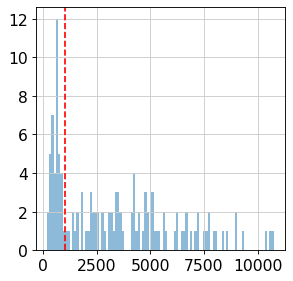

UA_Endo13646709_SE06


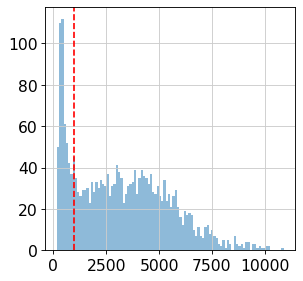

UA_Endo12961681_doublet


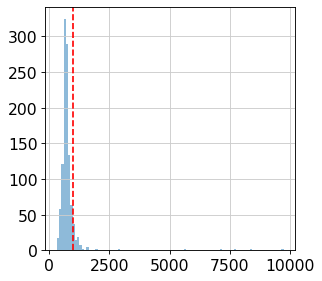

UA_Endo12961680_doublet


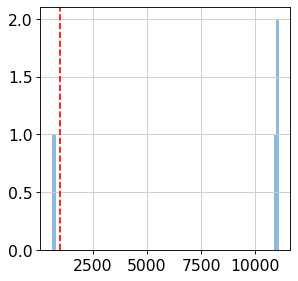

UA_Endo12680034_FX1249


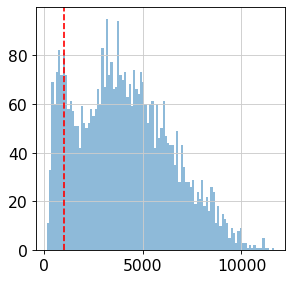

UA_Endo10298213_FX9006


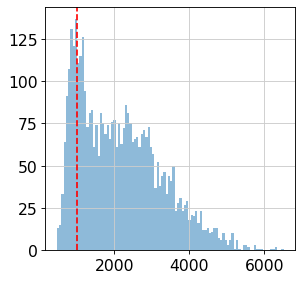

UA_Endo12961681_unassigned


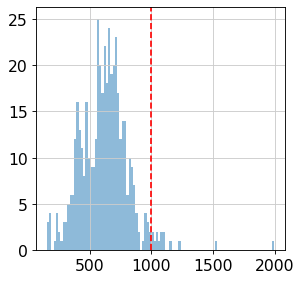

UA_Endo10298211_FX1176


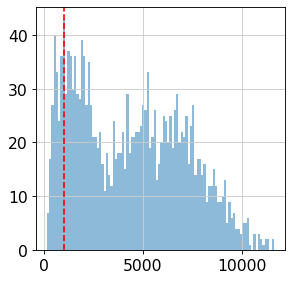

UA_Endo10298210_doublet


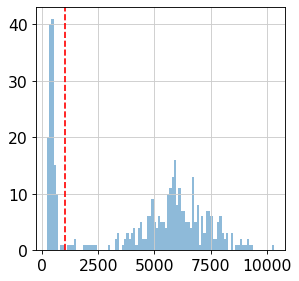

FRZFRESH_GX25_ES345


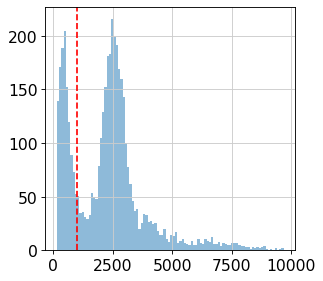

UA_Endo10298213_unassigned


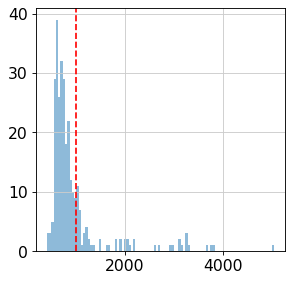

UA_Endo12961679_unassigned


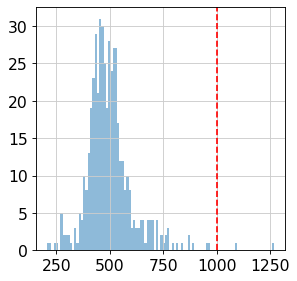

UA_Endo9426401_unassigned


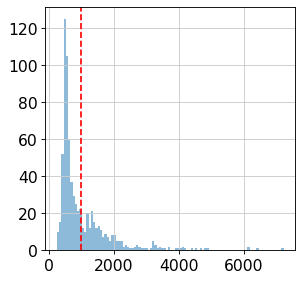

UA_Endo12961679_doublet


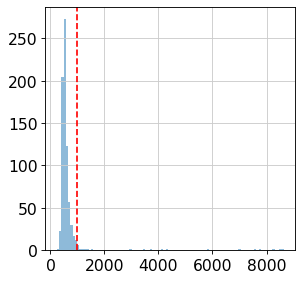

FRZFRESH_GX28_ES345


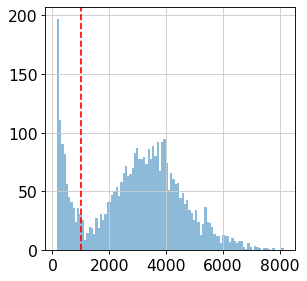

UA_Endo12680031_FX1119


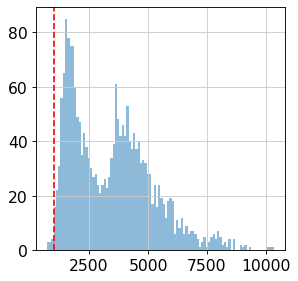

UA_Endo9426402_doublet


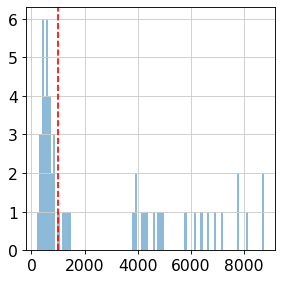

UA_Endo12680031_doublet


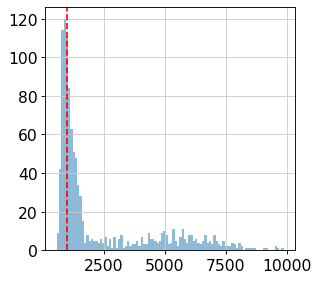

UA_Endo10298213_FX1156


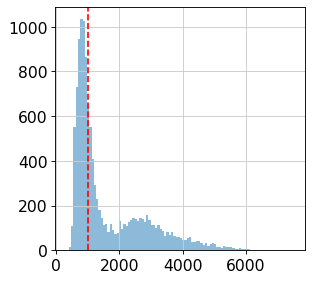

UA_Endo12961682_unassigned


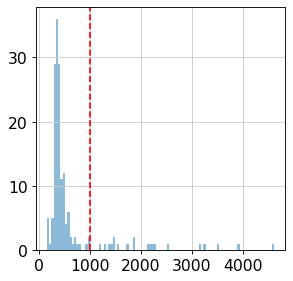

FRZFRESH_GX26_ES345


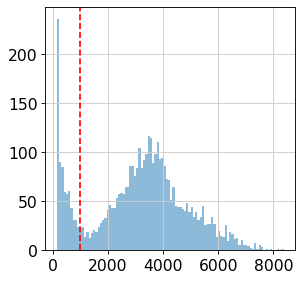

UA_Endo9426401_doublet


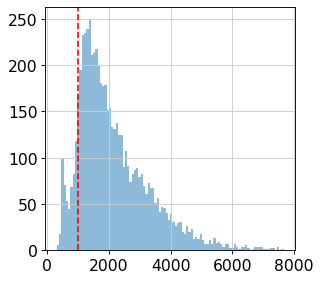

UA_Endo9426401_FX1156


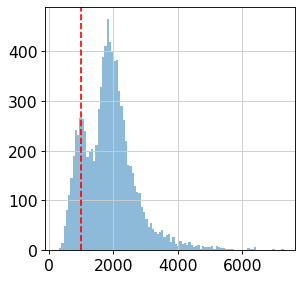

UA_Endo10768582_FX1253


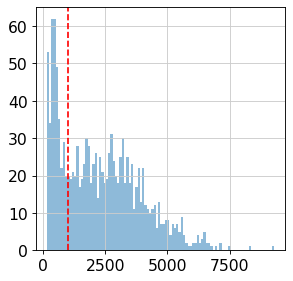

UA_Endo12680033_FX1249


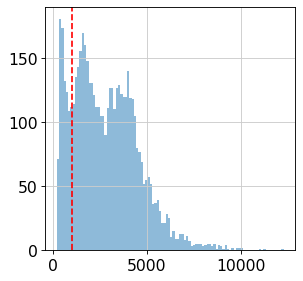

UA_Endo12961681_FX1289


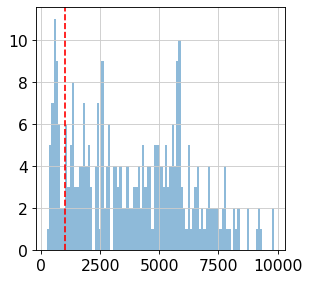

UA_Endo12961682_FX1289


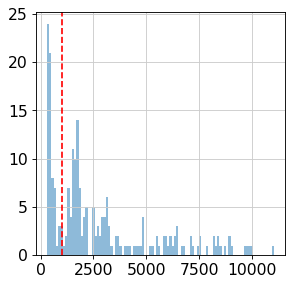

UA_Endo12680033_doublet


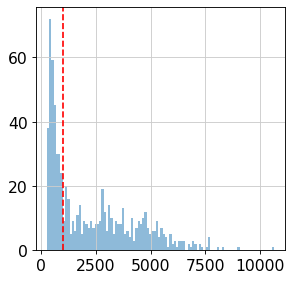

UA_Endo9426402_FX9006


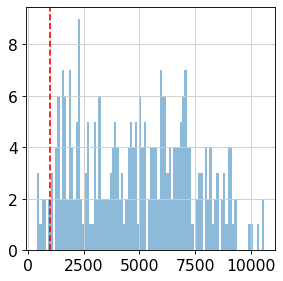

UA_Endo12961681_SE03


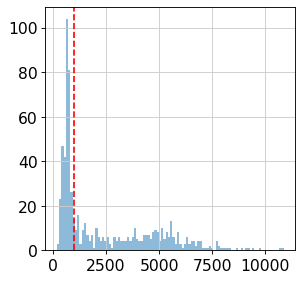

UA_Endo10298212_unassigned


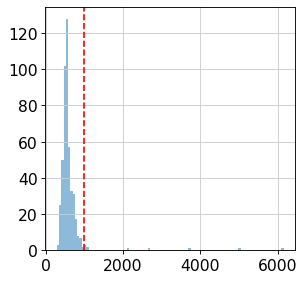

UA_Endo10298211_unassigned


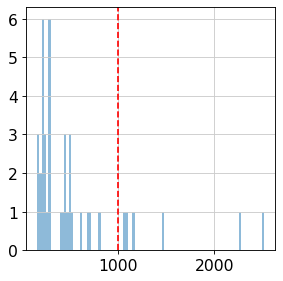

UA_Endo12680032_FX1259


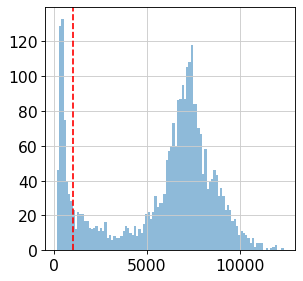

UA_Endo12680034_FX1254


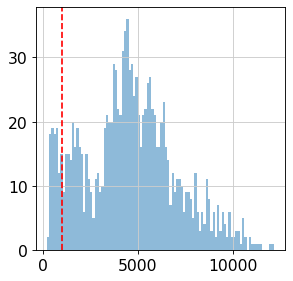

In [32]:
for sam in set(adata.obs.Library_genotype):
    print(sam)
    x = adata[[ i in sam for i in adata.obs.Library_genotype]]
    plt.figure()
    plt.hist(x.obs['n_genes'], bins = 100, alpha=0.5)
    plt.axvline(1000, linestyle = '--', color = 'red')
    plt.show()

In [33]:
sc.pp.filter_cells(adata, min_genes=1000)

filtered out 37521 cells that have less than 1000 genes expressed


In [34]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['Library_genotype'].values.describe()

Total number of cells: 133016
Total number of genes: 30442


,counts,freqs
categories,,
FRZFRESH_GX25_ES345,3217,0.024185
FRZFRESH_GX26_ES345,3427,0.025764
FRZFRESH_GX27_ES345,4124,0.031004
FRZFRESH_GX28_ES345,3063,0.023027
UA_Endo9426399_FX1146,12313,0.092568
UA_Endo9426400_FX1146,10955,0.082359
UA_Endo9426401_FX1156,7819,0.058782
UA_Endo9426401_FX9006,10597,0.079667
UA_Endo9426401_doublet,5504,0.041378



### Filter cells with large % mitochondrial genes

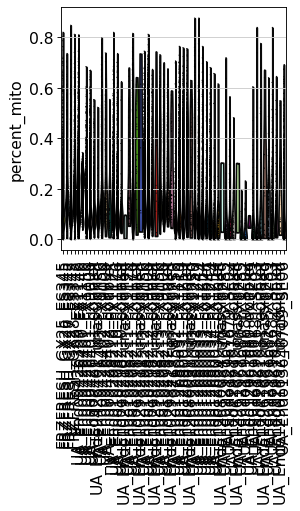

In [35]:
sc.pl.violin(adata, ['percent_mito'], groupby='sample', rotation = 90) #hPGCs

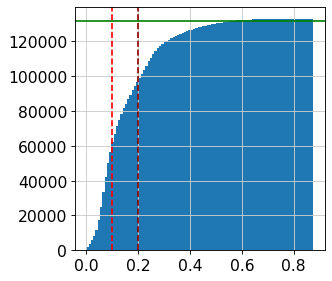

In [36]:
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(0.2, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [37]:
# >20%
adata = adata[adata.obs['percent_mito'] < 0.2, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [38]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['Library_genotype'].values.describe()

Total number of cells: 96199
Total number of genes: 30442


,counts,freqs
categories,,
FRZFRESH_GX25_ES345,2849,0.029616
FRZFRESH_GX26_ES345,2371,0.024647
FRZFRESH_GX27_ES345,3507,0.036456
FRZFRESH_GX28_ES345,1855,0.019283
UA_Endo9426399_FX1146,8585,0.089242
UA_Endo9426400_FX1146,2658,0.027630
UA_Endo9426401_FX1156,7214,0.074990
UA_Endo9426401_FX9006,9439,0.098120
UA_Endo9426401_doublet,5211,0.054169


### Remove cells with low counts high mito combo

In [39]:
# x = [ int(i) < 1500 for i in adata.obs['n_counts']]
# adata.obs['low_ncounts'] = [ str(i) for i in x ]

# y = [ i > 0.1 for i in adata.obs['percent_mito']]
# adata.obs['high_mito'] = [ str(i) for i in y ]

# mask = [all(tup) for tup in zip(x,y)]
# adata.obs['low_ncounts_high_mito'] = [ str(i) for i in mask ]

# adata = adata[[ 'False' in i for i in adata.obs['low_ncounts_high_mito']   ]] # there is a bug so I have to iterate ... sorry 

In [40]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['Library_genotype'].values.describe()
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

Total number of cells: 96199
Total number of genes: 30442


### Filter genes expressed in less than 3 cells

In [41]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 461 genes that are detected in less than 3 cells
Trying to set attribute `.var` of view, copying.
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [42]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['Library_genotype'].values.describe()

Total number of cells: 96199
Total number of genes: 29981


,counts,freqs
categories,,
FRZFRESH_GX25_ES345,2849,0.029616
FRZFRESH_GX26_ES345,2371,0.024647
FRZFRESH_GX27_ES345,3507,0.036456
FRZFRESH_GX28_ES345,1855,0.019283
UA_Endo9426399_FX1146,8585,0.089242
UA_Endo9426400_FX1146,2658,0.027630
UA_Endo9426401_FX1156,7214,0.074990
UA_Endo9426401_FX9006,9439,0.098120
UA_Endo9426401_doublet,5211,0.054169


### Identify cells behaving like cc genes
Per genes analysis: identify genes behaving like known cell cycle genes

In [43]:
bdata = adata.copy()
# Normalize total counts per cell
sc.pp.normalize_per_cell(bdata, counts_per_cell_after=1e4)
# Logarithmize the data matrix
sc.pp.log1p(bdata)

normalizing by total count per cell
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [44]:
# Extract highly variable genes
sc.pp.highly_variable_genes(bdata)
highly_variable_genes = bdata.var["highly_variable"]
bdata = bdata[:, highly_variable_genes]

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [45]:
# Traspose matrix for a GENE-centered analysis
bdata = bdata.copy().T

In [46]:
bdata.X.shape

(2698, 96199)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:24)


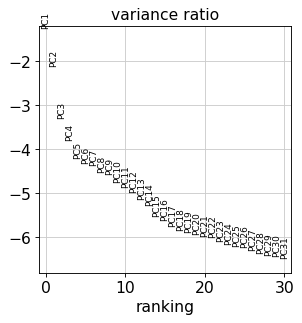

In [47]:
# Scale data to unit variance and zero mean
sc.pp.scale(bdata, max_value=10)

# Scatter plot in PCA coordinates
sc.tl.pca(bdata)
bdata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
# Plot the variance ratio
sc.pl.pca_variance_ratio(bdata, log=True, save='_ccg_identification.pdf')

In [48]:
num_pcs = 10
# Compute a neighborhood graph of observations
sc.pp.neighbors(bdata, n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(bdata)
# Cluster GENES into subgroups using louvain: resolution < 1 to find less clusters
sc.tl.louvain(bdata, resolution=1)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'known_cyclers' as categorical


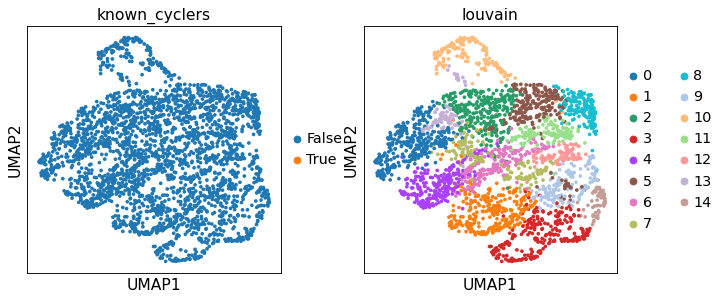

CCNB2    10
CDK1     10
MKI67    10
Name: louvain, dtype: category
Categories (15, object): ['0', '1', '2', '3', ..., '11', '12', '13', '14']


In [49]:
# Locate ccs cluster
bdata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in bdata.obs_names]
bdata.obs['known_cyclers'] = [ str(i) for i in  bdata.obs['known_cyclers']]
sc.pl.umap(bdata, color=['known_cyclers', 'louvain'], color_map='OrRd',save='_ccg_identification.pdf')
print(bdata.obs.loc[[i in ['CDK1','MKI67','CCNB2','PCNA'] for i in bdata.obs_names],'louvain'])

In [50]:
ccgs_cl = bdata.obs.loc['CDK1',['louvain']][0]
print("Cell cycle genes cluster is "+ccgs_cl)

Cell cycle genes cluster is 10


### Flag ccgs

In [51]:
# Add unstructured dict-like annotation for ccgs
adata.uns['ccgs'] = list(bdata.obs[bdata.obs['louvain']==ccgs_cl].index)

In [52]:
# Move plots
MovePlots('ccg_identification','ccg_identification')

# Score cell cycle

In [53]:
s_genes = [x.strip() for x in open('/home/jovyan/utils/S_genes.tsv')]
g2m_genes = [x.strip() for x in open('/home/jovyan/utils/G2M_genes.tsv')]

s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [54]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished: added
    'S_score', score of gene set (adata.obs).
    420 total control genes are used. (0:00:05)
computing score 'G2M_score'
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished: added
    'G2M_score', score of gene set (adata.obs).
    416 total control genes are used. (0:00:05)
-->     'phase', cell cycle phase (adata.obs)


## Load scrublet

In [55]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    scrdf.append(pd.read_csv('scrublet-scores/'+sample+'.csv', header=0, index_col=0))
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]

idx = [ i in adata.obs_names for i in scrdf.index ]
scrdf = scrdf[idx]
for score in scorenames:
    adata.obs[score] = scrdf[score]
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01

# Save raw counts

In [56]:
adata = adata[[ i not in ['doublet'] for i in adata.obs.genotype ]]
adata = adata[[ i not in ['unassigned'] for i in adata.obs.genotype ]]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [58]:
adata.write('/nfs/team292/lg18/endometriosis/raw_objects/cells_rawcounts.h5ad')

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


In [59]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
print('Total number of donors: {:d}'.format(len(set(adata.obs.genotype))))
print('Total number of samples: {:d}'.format(len(set(adata.obs['sample']))))
print('Total number of libraries: {:d}'.format(len(set(adata.obs['library']))))

Total number of cells: 88107
Total number of genes: 29981
Total number of donors: 16
Total number of samples: 35
Total number of libraries: 22


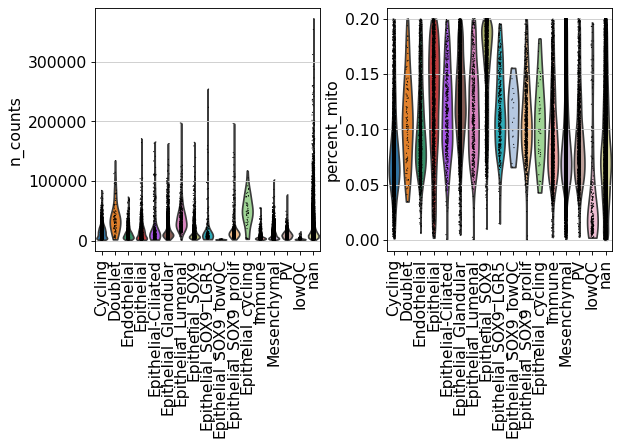

In [55]:
sc.pl.violin(adata, ['n_counts', 'percent_mito'], groupby='ssa_lineage', rotation = 90) #hPGCs

In [56]:
# adata = sc.read('/nfs/team292/lg18/endometriosis/cells_rawcounts.h5ad')

In [57]:
adata.obs['Binary Stage'].value_counts()
adata.obs['genotype'].value_counts()

FX9006    17101
FX1156    14796
FX1146    11243
ES345     10582
FX1259     8005
FX1249     6700
FX1254     6210
FX1125     4638
FX1176     3478
SE06       1500
FX1119     1332
SE03        869
FX1253      851
FX1289      372
FX1285      218
SE02        212
Name: genotype, dtype: int64